<h1 align="center"><u><b> ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ ΚΑΙ ΕΥΦΥΗ ΥΠΟΛΟΓΙΣΤΙΚΑ ΣΥΣΤΗΜΑΤΑ</b></u></h1>

<h2 align="center"><u><b> Εργασία 2<sup>η</sup></h2>
<ul>
<li>Παναγιώτης Παπαδέας 03118039</li>

<li>Εμμανουήλ Βλάσσης 03118086</li>

<li>Λαουρεντιάν Γκούμε 03118014</li>
</ul>

Στην παρούσα εργασία προσπαθούμε να δημιουργήσουμε ένα σύστημα συστάσεων ταινιών βασισμένο στο περιεχόμενο. Στη συνέχεια αφού το καταφέρουμε αυτό θα επιχειρήσουμε να δημιουργήσουμε μια τοπολογική απεικόνιση των ταινιών που χρησιμοποιήσαμε για το μοντέλο μας. 
Εισάγουμε λοιπόν τις απαραίτητες βιβλιοθήκες.

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.8 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8
    Uninstalling nltk-3.8:
      Successfully uninstalled nltk-3.8
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-p

In [2]:
!pip install --upgrade somoclu
import somoclu
import matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


**Εισαγωγή του dataset**

Αρχικά εισάγουμε το dataset.

In [3]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Ορίζουμε team_seed_number=11 ώστε να λάβουμε τις ταινίες που ανήκουν στην ομάδα μας και μαζεύουμε τα χαρακτηριστικά κάθε ταινίας στις αντίστοιχες μεταβλητές (**titles**, **categories**, **catbins**, **summaries**, **corpus**, **corpus_df**)

In [4]:
import numpy as np

# Στην επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 11

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

<h2><u><b> Μέρος 1. Σύστημα συστάσεων βασισμένο στο περιεχόμενο</b></u></h2>

In [5]:
import nltk
import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import collections

#download tokenizers
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('rslp')
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /home/manos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/manos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/manos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /home/manos/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Δημιουργούμε τις κατάλληλες συναρτήσεις thorough_filter και preprocess_document για την προεπεξεργασία των δεδομένων μας. Με την thorough_filter αφαιρούμε τα σημεία στίξης από τις λέξεις μας ενώ με την preprocess_document η οποία καλεί την thorough_filter επεξεργαζόμαστε πλήρως τα δεδομένα μας (αφαίρεση κοινών λέξεων (stopwords), μετατροπή κεφαλαίων σε πεζά, διαχωρισμός των λέξεων κλπ) και τυπώνουμε την συνχότητα κάθε token σε κάθε document.

In [6]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            if word != "'s":
                filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
    return stemmed_words

Χρησιμοποιούμε τη συνάρτηση preprocess_document για να επεξεργαστούμε κάθε σύνολο δεδομένων ξεχωριστά.

In [7]:
#preprocess titles
preprocessed_titles = [preprocess_document(title[0]) for title in titles]

#preprocess categories
preprocessed_categories = [preprocess_document(cat.replace("/"," ").replace("-"," "))  for cats in categories for cat in cats]

#preprocess summaries
preprocessed_summaries = [preprocess_document(summary[0].replace("/"," ").replace("-"," "))  for summary in summaries ]
preprocessed_summaries = [[token for token in ncorpus if len(token) > 2] for ncorpus in preprocessed_summaries]
preprocessed_summaries = [' '.join(sublist) for sublist in preprocessed_summaries]

#preprocess corpus
preprocessed_corpus = [preprocess_document(corp.replace("/"," ").replace("-"," "))  for corp in corpus ]
token_preprocessed_corpus = [[token for token in ncorpus if len(token) > 2] for ncorpus in preprocessed_corpus]
preprocessed_corpus = [' '.join(sublist) for sublist in token_preprocessed_corpus]

Στη συνέχεια μετατρέπυμε το corpus σε αναπαράσταση tfidf μέσω της συνάρτησης Τfidfvectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create sparse tf_idf representation
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(preprocessed_corpus)
tfidfcorpus_plain = tfidfvectorizer.transform(preprocessed_corpus)

In [9]:
import scipy as sp
import numpy.linalg as LA

Τέλος δημιουργούμε το μοντέλο μας μέσω της συνάρτησης content_recommender που λαμβάνει ορίσματα την ταινία το πλήθος ταινιών που σχετίζονται με την ταινία και θα μας προτείνει καθώς και τον τύπο του corpus. Η conent_recommender χρησιμοποιεί την cosine_function για να βρει αντίστοιχες ταινίες.


In [25]:
cosine_fun = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 4)

def content_recommender(target_movie, max_recommendations, corpus_type):
    dist = np.zeros(len(corpus))
    movies = corpus_type[target_movie]
    for i in range(len(corpus_type)):
        dist[i] = cosine_fun(movies, corpus_type[i])
    indexes = (-dist).argsort()[:max_recommendations+1]
    print("ID of target movie:", target_movie)
    print("Title: ", titles[target_movie][0])
    print("Synopsis: ", summaries[target_movie][0])
    print("Categories: ", categories[target_movie][0])
    print()
    for i in range(1, max_recommendations+1):
        print(i, ". cosine similarity: ", dist[indexes[i]])
        print("ID: ", indexes[i], " title: ", titles[indexes[i]][0])
        print("Synopsis: ", summaries[indexes[i]][0])
        print("Categories: ", categories[indexes[i]][0])
        print()

content_recommender(78, 5, tfidfcorpus_plain.toarray())        

ID of target movie: 78
Title:  Champagne
Synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry but i

Παρατηρούμε ότι με τον out-of-the box tfidfvectorizer αυξημένη ομοιότητα συνημιτόνου εμφανίζουν ταινίες με ίδιο όνομα πρωταγωνίστριας. Για την targe ταινία μας όπου η πρωταγωνίστρια ονομαζόταν Heiress Betty βλέπουμε ότι μας προτείνει αρκετές ταινίες με το όνομα Betty στον τίτλο τους. Επίσης είανι πιθανό να μας εμφανίζει προτάσεις ταινιών με εκτενής περιγραφή εξαιτίας του μεγάλου πλήθους λέξεων που περιέχουν ακόμα και αν δεν έχουν σημαντική συσχέτιση με την ταινία στόχο μας.

# **Βελτιστοποίηση του Tfidfvectorizer**

Θα επιχειρήσουμε να τροποποιήσουμε τις παραμέτρους max - df: για να αγνοήσουμε λέξεις με υψηλή συχνότητα που δεν αφαιέθηκαν πορηγουμένως ως stopwords, min -df: για να αγνοήσουμε λέξεις που εμφανίζονται αρκετά σπάνια και δεν παίζουν ρόλο στην πλοκή ngramrange kai maxfeatures για να μειώσουμε την διαστατικότητα και να επιτύχουμε γρηγορότερη επεξεργασία.

**Δοκιμή 1**: max_df=0.9, min_df=0.001, ngram_range=(1,2)

In [23]:
print("Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer: ", 
    tfidfcorpus_plain.shape)
vectorizer1 = TfidfVectorizer(max_df=0.9, min_df=0.001, ngram_range=(1,2), stop_words='english')
tfidfcorpus_optimized_1 = vectorizer1.fit_transform(preprocessed_corpus)
print("Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:  ",
    tfidfcorpus_optimized_1.toarray().shape)

Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer:  (5000, 35183)
Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:   (5000, 17214)


In [26]:
content_recommender(100, 5, tfidfcorpus_optimized_1.toarray())

ID of target movie: 100
Title:  Banzai Runner
Synopsis:  A yearly every-man-for-himself car race is staged in the desert, with wealthy motorists driving custom cars at supersonic speed on a deserted highway. During one of these contests, a policeman is killed. With no witnesses, it's up to the cop's brother to see justice is done. He accomplishes this by assuming a false identity and joining the race.
Categories:  "Thriller",  "Sports",  "Indie",  "Action/Adventure",  "Action",  "Auto racing"

1 . cosine similarity:  0.1876
ID:  4135  title:  Redline
Synopsis:  "Sweet JP" - rightfully named for his personality, retro style, and refusal to mount weapons on his racecar - nearly wins the "Yellowline" race against a host of semi-pro alien drivers, most of whom use oversized vehicles with jet engines mounted with guns and missiles, but just before the finish line JP's car is sabotaged by an explosive device placed by his friend and mechanic; Frisbee. In the past, Frisbee and JP were sent to

Παρατηρούμε ότι εξάγουμε ταινίες με σχετικά κοντινό περιεχόμενο ακόμα και για αύξηση του πλήθους των προτεινόμενων ταινιών σε 7.

**Δοκιμή 2**: max_df=0.5, min_df=0.002, ngram_range=(1,2)

In [15]:
print("Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer: ", 
    tfidfcorpus_plain.shape)
vectorizer2 = TfidfVectorizer(max_df=0.5, min_df=0.002, ngram_range=(1,2), stop_words='english')
tfidfcorpus_optimized_2 = vectorizer2.fit_transform(preprocessed_corpus)
print("Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:  ",
    tfidfcorpus_optimized_2.toarray().shape)

Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer:  (5000, 35183)
Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:   (5000, 7970)


In [27]:
content_recommender(100, 5, tfidfcorpus_optimized_2.toarray())

ID of target movie: 100
Title:  Banzai Runner
Synopsis:  A yearly every-man-for-himself car race is staged in the desert, with wealthy motorists driving custom cars at supersonic speed on a deserted highway. During one of these contests, a policeman is killed. With no witnesses, it's up to the cop's brother to see justice is done. He accomplishes this by assuming a false identity and joining the race.
Categories:  "Thriller",  "Sports",  "Indie",  "Action/Adventure",  "Action",  "Auto racing"

1 . cosine similarity:  0.2756
ID:  4135  title:  Redline
Synopsis:  "Sweet JP" - rightfully named for his personality, retro style, and refusal to mount weapons on his racecar - nearly wins the "Yellowline" race against a host of semi-pro alien drivers, most of whom use oversized vehicles with jet engines mounted with guns and missiles, but just before the finish line JP's car is sabotaged by an explosive device placed by his friend and mechanic; Frisbee. In the past, Frisbee and JP were sent to

Παρατηρούμε καλά αποτελέσματα για ταινίες με ικανοποιητικές κριτικές, συνεχίζουμε όμως να έχουμε μη ικανοποιητικά αποτελέσματα για ταινίες με μη σχετικές προτάσεις.

Δοκιμή 3: max_df=0.4, min_df=0.0015, ngram_range=(1,2)

In [17]:
print("Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer: ", 
    tfidfcorpus_plain.shape)
vectorizer3 = TfidfVectorizer(max_df=0.4, min_df=0.0015, ngram_range=(1,2), stop_words='english')
tfidfcorpus_optimized_3 = vectorizer3.fit_transform(preprocessed_corpus)
print("Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:  ",
    tfidfcorpus_optimized_3.toarray().shape)

Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer:  (5000, 35183)
Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:   (5000, 9996)


In [28]:
content_recommender(100, 7, tfidfcorpus_optimized_3.toarray())

ID of target movie: 100
Title:  Banzai Runner
Synopsis:  A yearly every-man-for-himself car race is staged in the desert, with wealthy motorists driving custom cars at supersonic speed on a deserted highway. During one of these contests, a policeman is killed. With no witnesses, it's up to the cop's brother to see justice is done. He accomplishes this by assuming a false identity and joining the race.
Categories:  "Thriller",  "Sports",  "Indie",  "Action/Adventure",  "Action",  "Auto racing"

1 . cosine similarity:  0.2124
ID:  4135  title:  Redline
Synopsis:  "Sweet JP" - rightfully named for his personality, retro style, and refusal to mount weapons on his racecar - nearly wins the "Yellowline" race against a host of semi-pro alien drivers, most of whom use oversized vehicles with jet engines mounted with guns and missiles, but just before the finish line JP's car is sabotaged by an explosive device placed by his friend and mechanic; Frisbee. In the past, Frisbee and JP were sent to

Βλέπουμε ότι οτι προτάσεις για τις ταινίες στόχους που παρουσίαζαν ικανοποιητικές προτάσεις εξακολουθούν να είναι καλές, ενώ οι ταινίες με μη σχετικές προτάσεις δεν έχουν βελτιωθεί.

**Δοκιμή 4**: max_df=0.001, min_df=0.0009, ngram_range=(1,2)

In [21]:
print("Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer: ", 
    tfidfcorpus_plain.shape)
vectorizer4 = TfidfVectorizer(max_df=0.001, min_df=0.0009, ngram_range=(1,2), stop_words='english')
tfidfcorpus_optimized_4 = vectorizer4.fit_transform(preprocessed_corpus)
print("Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:  ",
    tfidfcorpus_optimized_4.toarray().shape)

Dimensions of TF-IDF before optimizing parameters of TfidfVectorizer:  (5000, 35183)
Dimensions of TF-IDF after optimizing parameters of TfidfVectorizer:   (5000, 3461)


In [29]:
content_recommender(10, 5, tfidfcorpus_optimized_4.toarray())

ID of target movie: 10
Title:  Ganga Ki Kasam
Synopsis:  Ganga Ki Kasam is an Action flick from Mithun-T L V Prasad team. Jackie Shroff too added in the Cast.
Categories:  "Drama"

1 . cosine similarity:  0.9878
ID:  3068  title:  Khalnayak
Synopsis:  Ballu  is a gangster who is arrested by Inspector Ram . Ram shows compassion to Ballu while trying to get him to provide information that would lead to capture of Ballu's boss and mentor Roshida. Ballu does not speak, and he promises to escape from the jail. Ballu escapes from jail while Ram is visiting his girlfriend Ganga  who is also a police officer. When news of this breaks out, Ram's reputation is in tatters as the media portrays Ram as an officer who has neglected his duty. Ganga, in an attempt to restore Ram's reputation, secretly goes undercover as a street-girl. Ganga realises that Ballu is a good-hearted person who turned to crime due to poverty and circumstances. Ganga tries to rehabilitate Ballu while on the run. Meanwhile Ba

/tmp/ipykernel_3527/311154126.py:1: RuntimeWarning: invalid value encountered in scalar divide
  cosine_fun = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 4)


Παρατηρούμε ότι μειώνοντας τόσο δραστικά το max_df σε 0.001 οι προτάσεις που λαμβάνουμε ακόμα και για ταινίες για τις οποίες είχαμε καλά αποτελέσματα, δεν είναι ικανοποιητικές. 
Συνεπώς, εξάγουμε το συμπέρασμα ότι έχουμε καλύτερα αποτελέσματα με παραμέτρους παρόμοιες με αυτές των τριών πρώτων δοκιμών καθώς και με μείωση του min_df.

# Bαθιά μάθηση: Δημιουργία corpora με χρήση word embeddings

# Εμφυτεύματα του Gensim-data

In [30]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

Defaulting to user installation because normal site-packages is not writeable
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Εισάγουμε τα μοντέλα μας

In [32]:
# Τα δύο μοντέλα μας, ο αριθμός αντιστοιχεί σε διαστάσεις
model1 = gensim.downloader.load("glove-twitter-25")

model2 = gensim.downloader.load("glove-twitter-100")

Στη συνέχεια δημιουργούμε την κατάλληλη συνάρτηση build_tf2w και κατασκεύάζουμε το recommender σύστημά μας βασισμένο στο w2v

In [37]:
def build_tfw2v(corpus, vectors, embeddings_size, min_df=1, max_df=1.0):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    vectorizer.fit(corpus)
    tf_idf = vectorizer.transform(corpus).toarray()
    new_corpus = []
    for idx, movie_corpus in enumerate(corpus):
        tf_idf_w2v = np.zeros(embeddings_size)
        tf_idf_acc = 0
        for word in movie_corpus.split(' '):
            col_idx = vectorizer.vocabulary_.get(word)
            if col_idx:
                tf_idf_w = tf_idf[idx][col_idx]
            else:
                tf_idf_w = 0
            tf_idf_acc = tf_idf_acc + tf_idf_w
            try:
                w2v = vectors.get_vector(word)
            except KeyError:
                w2v = np.zeros(embeddings_size)
            tf_idf_w2v = tf_idf_w2v + (tf_idf_w * w2v)
        new_corpus.append(tf_idf_w2v / tf_idf_acc)
    return np.array(new_corpus)

In [35]:
def w2vcontent_recommender(target_movie, max_recommendations, corpus_type):
    dist = np.zeros(len(corpus))
    movies = corpus_type[target_movie]

    for i in range(len(corpus_type)):
        dist[i] = cosine_fun(movies, corpus_type[i])
        
    indexes = (-dist).argsort()[:max_recommendations]
    print("ID of target movie:", target_movie)
    print("Title: ", titles[target_movie][0])
    print("Synopsis: ", summaries[target_movie][0])
    print("Categories: ", categories[target_movie][0])
    print()

    for i in range(1, max_recommendations):
        print(i, ". cosine similarity: ", dist[indexes[i]])
        print("ID: ", indexes[i], " title: ", titles[indexes[i]][0])
        print("Synopsis: ", summaries[indexes[i]][0])
        print("Categories: ", categories[indexes[i]][0])
        print()

Θα δοκιμάσουμε αρχικά το κάθε μοντέλο πρώτα με τις αρχικές παραμέτρους min_df=1, max_df=1 και έπειτα με τις βελτιστοποιημένες και θα συγκρίνουμε τις επιδόσεις σε κάθε περίπτωση.

In [38]:
w2v_corpus1 = build_tfw2v(preprocessed_corpus, model1, 25)
w2v_corpus2 = build_tfw2v(preprocessed_corpus, model2, 100)
w2v_corpus1_optimized = build_tfw2v(preprocessed_corpus, model1, 25, 0.0015, 0.9)
w2v_corpus2_optimized = build_tfw2v(preprocessed_corpus, model2, 100, 0.0015, 0.9)

**Μη βελτιστοποιημένο μοντέλο "glove-twitter-25" min_df=1, max_df=1**

In [39]:
w2vcontent_recommender(78, 5, w2v_corpus1)

ID of target movie: 78
Title:  Champagne
Synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry but i

**Μη βελτιστοποιημένο Mοντέλο "glove-twitter-100" min_df=1, max_df=1**

In [41]:
w2vcontent_recommender(78, 5, w2v_corpus2)

ID of target movie: 78
Title:  Champagne
Synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry but i

**Βελτιστοποιημένο Mοντέλο "glove-twitter-25" min_df=0.0015, max_df=0.9**

In [43]:
w2vcontent_recommender(78, 5, w2v_corpus1_optimized)

ID of target movie: 78
Title:  Champagne
Synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry but i

**Mοντέλο "glove-twitter-100" min_df=0.0015, max_df=0.9 (βελτιστοποιημένο)**

In [44]:
w2vcontent_recommender(78, 5, w2v_corpus2_optimized)

ID of target movie: 78
Title:  Champagne
Synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry but i

# **Συμπεράσματα - Σχόλια**

Κατά τη διαδικασία της προεπεξεργασίας μετατρέπουμε όλα τα γράμματα κάθε λέξης σε πεζά, αφού ο υπολογιστής θεωρεί τα κεφαλαία και τα μικρά ως διαφορετικούς χαρακτήρες. Στη συνέχεια, αφαιρούμε από το corpus τα σημεία στίξης και τα stopwords τα οποία αποτελούν συχνά χρησιμοποιούμενες λέξεις οι οποίες δεν προσφέρουν ιδιαίτερη σημασιολογική αξία στο κείμενο και ενδεχομένως να καθυστερούν και να δυσχεραίνουν την πρόταση σχετικών ταινιών. Επιπλέον, αφαιρούμε τους χαρακτήρες "/", "-" και τα strings " 's" που δεν είχαν νοημα να παραμένουν ως tokens. Τέλος, για να αποφύγουμε το πρόβλημα της προσθήκης επιπλέον διάστασης στην αναπαράσταση λέξεων με παρόμοιο σημασιολογικό περιεχόμενο, επιλέγουμε την τεχνική του stemming (αντί του lemmatization), διότι μας μειώνει πιο αποτελεσματικά τις διαστάσεις των δεδομένων μας και ευνοεί την οικονομία χρόνου.

Κατά τη βελτιστοποίηση της TfidfVectorizer επιλέγουμε αρχικά παραμέτρους max_df=0.9, min_df=0.0004, ngram_range=(1,2). Μειώνουμε σταδιακά τα max_fd & min_df και ελέγχoυμε τι προτάσεις ταινιών έχουμε λάβει. Παρατηρούμε ότι για τα ζεύγη max_df=0.9 & min_df=0.0004, max_df=0.5 & min_df=0.002, max_df=0.4 & min_df=0.0015 λαμβάνουμε παρόμοια αποτελέσματα χωρίς όμως να βελτιώνονται οι προτάσεις για ταινίες με μη σχετικά recommendations. Ακόμη, θέτοντας πολύ μικρές τιμές στο max_df, παρατηρούμε ότι χειροτερεύουν οι συστάσεις ταινιών.

Cherry picking IDs αποτελούν τα: 100, 123, 167 όπου τόσο οι πλοκές, όσο και οι κατηγορίες των ταινιών είναι σχετικές μεταξύ τους και άρα καταλαβαίνουμε ότι ο recommender μας έχει κάνει ικανοποιητικές προτάσεις.

Nir-picking IDs αποτελούν τα: 1, 24, 78 όπου δίνουν την εντύπωση τυχαίων προτάσεων ταινιών στην εκάστοτε ταινία στόχο καθώς δεν εμφανίζουν ιδιαίτερη συσχέτιση.

Ως γενικό συμπέρασμα θα μπορούσαμε να παραθέσουμε ότι ο TF-IDF recommender, στο dataset μας, κάνει καλές προτάσεις για ταινίες πολύ συγκεκριμένων κατηγοριών (πχ, rally races ID:100), ενώ παρουσιάζει μη ικανοποιητικά αποτελέσματα για ταινίες στις οποίες οι χαρακτήρες έχουν κοινά ονόματα παραθέτοντας τες ως όμοιες. Οι προτάσεις ταινιών για ID=78, στην οποία η πρωταγωνίστρια ονομαζόταν Heiress Betty, ήταν ταινίες με τίτλους: Betty Boop's Big Boss, Betty Boop's Birthday Party,Betty in Blunderland, Betty Boop's Ker-Choo. Επιπλέον, συχνά εμφανίζει ως προτεινόμενες ταινίες, ταινίες με μεγάλη σύνοψη εξαιτίας του αυξημένου πλήθους λέξεων που περιλαμβάνουν, γεγονός όμως που δεν αποτελεί ικανοποιητική πρόταση.

To TF-IDF απιδίδει βάρος σε κάθε λέξη σύμφωνα με τη συχνότητα εμφάνισης ενός όρου σε ένα document και του λογαρίθμου του αριθμού των documents προς τον αριθμό των κειμένων στους οποίους εμφανίζεται η κάθε λέξη.
Η βασική του μετρική επομένως αποδίδει βάρη στους πιο περιγραφικούς όρους ενός document και υπολογίζει εύκολα την ομοιότητα συνημιτόνου μεταξύ δύο documents.
Ωστόσο, η μέθοδος αυτή απαιτεί πολύ χρόνο ιδίως όταν εργαζόμαστε σε μεγάλα corpus ενώ θεωρεί ότι διαφορετικές λέξεις έχουν διαφορετική απόδειξη ομοιότητας και αγνοεί την σημασιολογική ομοιότητα μεταξύ των λέξεων (bag of words μοντέλο).


**Σύγκριση σε σχέση με recommenders βασισμένων στο Word2Vec**

Παρατηρούμε πως οι recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα παρουσιάζουν πολύ καλά αποτελέσματα και για ταινίες στόχους, για τις οποίες είχαμε καλές προτάσεις (IDs: 100, 123, 167) καθώς επίσης και για τις ταινίες-στόχους, όπου δεν είχαμε προτάσεις συναφείς με το περιεχόμενο (IDs 1,24,78) και εξαλείφεται πλέον το πρόβλημα πρότασης ταινιών με ονόματα πρωταγωνιστών κοινά με την ταινία στόχο. Επιπλέον, απαλείφθηκαν και οι προτάσεις ταινιών με εκτενή σύνοψη που θεωρούταν σχετικές μόνο και μόνο για τον αυξημένο αριθμό λέξεών τους. Ακόμα και για αυξημένο πλήθος max reccomendation τα αποτελέσματα είναι ικανοποιητικά.

Παρατηρούμε πως οι ταινίες που προτείνονται από τους word2vec recommenders είναι πάντα σχετικές με την ταινία στόχο και εμφανίζουν πολύ υψηλό cosine similarity. To μόνο που αλλάζει βελτιστοποιοώντας τις παραμέτρους είναι η σειρά με την οποία προτείνονται οι ταινίες, προκειμένου η προτεραιότητα παρουσίασής τους να είναι πιο συμβατή με την ταινία στόχο. Όσο αφορά την ανάλυση των ποσοτικών χαρακτηριστικών, παρατηρούμε ότι όταν αυξήθηκε ο αριθμός των embeddings από 25 σε 100, η λήψη του δεύτερου μοντέλου καθυστέρησε λίγο παραπάνω, ενώ η εξαγωγή των αποτελεσμάτων με την w2v_content_recommender σε σχέση με το μοντέλο με τα λιγότερα embeddings διήρκησε τον ίδιο χρόνο.


## Persistence αντικειμένων

Αποθηκεύουμε τα corpora με τη βιβλιοθήκη joblib για να μπορούμε να τα ανακτήσουμε εύκολα

In [48]:
import joblib
joblib.dump(w2v_corpus1, 'w2v_corpus1.pkl') 
joblib.dump(w2v_corpus2, 'w2v_corpus2.pkl') 

joblib.dump(w2v_corpus1_optimized, 'w2v_corpus1_optimized.pkl') 
joblib.dump(w2v_corpus2_optimized, 'w2v_corpus2_optimized.pkl') 

['w2v_corpus2_optimized.pkl']

In [ ]:
# Αν χρειαστεί μπορούμε να εκτελέσουμε αυτό το κελί για να ανακτήσουμε τα corpora
w2v_corpus1 = joblib.load('w2v_corpus1.pkl') 
w2v_corpus2 = joblib.load('w2v_corpus2.pkl') 

w2v_corpus1_optimized = joblib.load('w2v_corpus1_optimized.pkl') 
w2v_corpus2_optimized = joblib.load('w2v_corpus2_optimized.pkl') 

## Εφαρμογή 2. Τοπολογική και σημασιολογική απεικόνιση των ταινών με χρήση SOM

## Δημιουργία dataset
Για την τοπολογική απεικίνιση των ταινιών με SOM θα αξιοποιήσουμε τα corpora που δημιουργήσαμε και σχολιάσαμε στο πρώτο μέρος της εργασίας. Συγκεκριμένα, διαλέγουμε το βελτιστοποιημένο corpus με βάση το μοντέλο 'glove-twitter-100'.

In [50]:
my_best_corpus = w2v_corpus2_optimized

def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return np.array(final_set, dtype=np.float32) # correct type

In [52]:
print("Corpus dimensions: ", my_best_corpus.shape)
print("Catbins dimensions: ", catbins.shape)

# Κατασκευή το τελικού corpus με τα catbins
cor = np.concatenate((my_best_corpus, catbins), axis=1)
print("Final set dimensions: ", cor.shape)

Corpus dimensions:  (5000, 100)
Catbins dimensions:  (5000, 322)
Final set dimensions:  (5000, 422)


## Εκπαίδευση χάρτη SOM

In [ ]:
import joblib
import somoclu
import matplotlib

n = 10
epochs = 100
som1 = somoclu.Somoclu(n, n, compactsupport=False)
%time som1.train(final_set, epochs=epochs) # Χρησιμοποιούμε όλο το set των ταινιών
#joblib.dump(som1, 'som1.pkl') 

CPU times: user 1min 8s, sys: 126 ms, total: 1min 8s
Wall time: 5.18 s


['som1.pkl']

## Best matching units

In [ ]:
bmus = som1.bmus
print(bmus.shape)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of unique bmus is: ", len(ubmus))
print(indices)

(5000, 2)
The number of the unique best matching units:  99
[60 77 70 ...  7  2 68]
99


## Ομαδοποίηση (clustering)

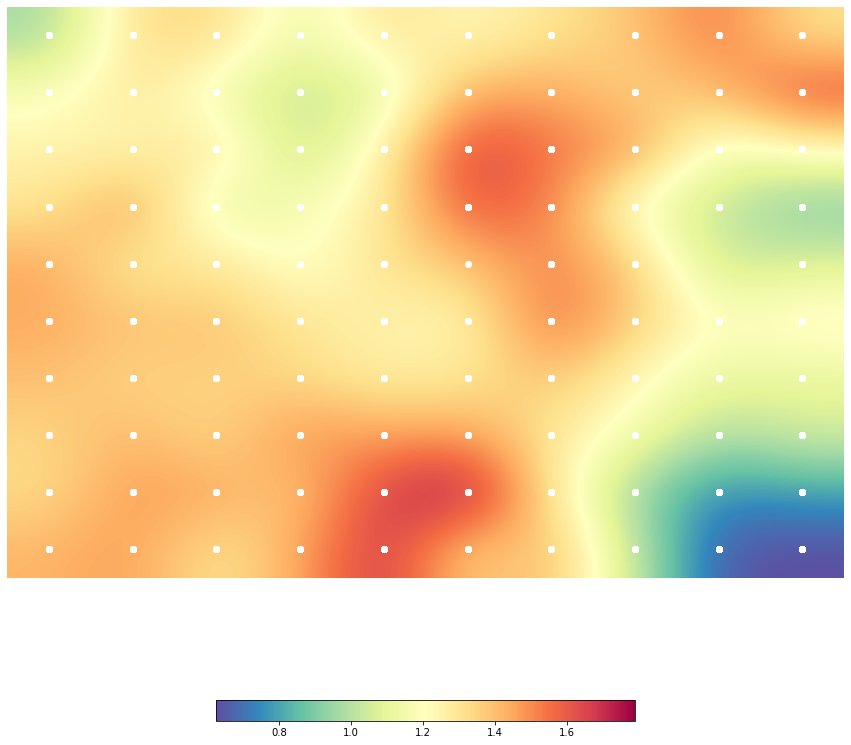

<module 'matplotlib.pyplot' from '/home/manos/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [ ]:
som1.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

## Ομαδοποίηση με kmeans

/home/manos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


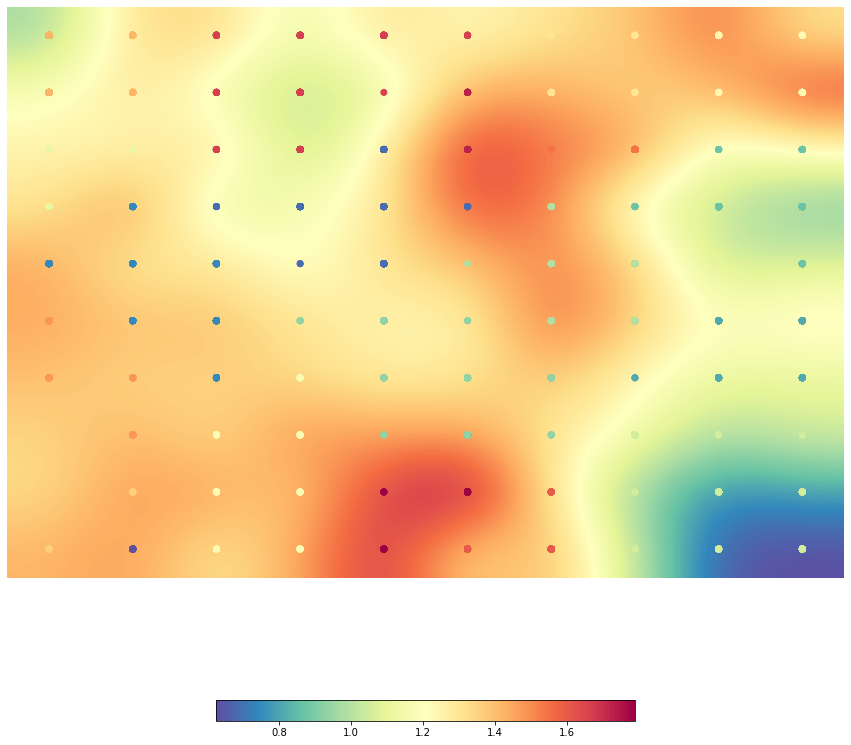

[[13 13 17 17 17 17 11 11 10 10]
 [13 13 17 17 17 18 11 11 10 10]
 [ 8  8 17 17  1 18 15 15  4  4]
 [ 8  2  1  1  1  1  6  4  4  4]
 [ 2  2  2  1  1  6  6  6  4  4]
 [14  2  2  5  5  5  6  6  3  3]
 [14 14  2  9  5  5  5  3  3  3]
 [12 14  9  9  5  5  5  7  7  7]
 [12 12  9  9 19 19 16  7  7  7]
 [12  0  9  9 19 16 16  7  7  7]]
The number of the unique best matching units:  99
The bmus for each movie are:  [60 77 70 ...  7  2 68]
The clusters and the number of nodes in descending order are:  [[17, 5, 7, 1, 4, 2, 9, 6, 3, 13, 11, 10, 14, 12, 8, 19, 16, 18, 15, 0], [9, 9, 9, 7, 7, 7, 7, 6, 5, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 1]]


In [ ]:
from sklearn.cluster import KMeans
from collections import Counter
import operator
algorithm = KMeans(n_clusters=20)
som1.cluster(algorithm=algorithm)
som1.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

print(som1.clusters)
bmus = som1.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of unique bmus is: ", len(ubmus))
print("The bmus for each movie are: ", indices)

# Get the largest and smallest clusters by number of nodes (movies)
counter = Counter(som1.clusters.flatten())
sorted_clusters = []
# Sort by values in counter
sorted_clusters.append([k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
sorted_clusters.append([v for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
print("The clusters and the number of nodes in descending order are: ", sorted_clusters)

## Σημασιολογική ερμηνεία των Clusters

Πρώτα ορίζουμε τις συναρτήσεις print_categories_stats(), print_clusters_neurons_movies_report(), και neuron_movies_report()

In [ ]:
import operator

# Get the categories of all movie ids in a dictionary (not sorted)
def print_categories_stats(movie_ids):
    total_categories = []
    for i in movie_ids:
        cats = categories[i][0].replace('"', "").split(',')
        cats = [j.strip() for j in cats]
        total_categories.extend(cats)
    (unique, counts) = np.unique(total_categories, return_counts=True)
    frequencies = dict(zip(unique, counts))
    frequencies = dict(sorted(frequencies.items(), key=operator.itemgetter(1), reverse=True))

    return frequencies  

# Gets a cluster number and a som object and returns the indices of the bmus
def print_cluster_neurons_movies_report(cluster_number, som):
    A,B = np.where(som.clusters == cluster_number)
    inds = np.column_stack((A,B))
    neuron_indices = []
    for i in range(len(inds)):
        for ubmu in ubmus:
            if inds[i][0] == ubmu[0] and inds[i][1] == ubmu[1]:
                neuron_indices.append(ubmu[1]*som.umatrix.shape[0] + ubmu[0]) 
                break
    
    return neuron_indices

def neuron_movies_report(neurons):
    movies = []
    for n in neurons:
        movies.extend(np.where(indices == n)[0])
    return print_categories_stats(movies)

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(10, som1))

{'Horror': 305,
 'Science Fiction': 78,
 'Slasher': 51,
 'B-movie': 35,
 'World cinema': 34,
 'Cult': 32,
 'Indie': 29,
 'Comedy': 27,
 'Creature Film': 26,
 'Teen': 24,
 'Supernatural': 22,
 'Zombie Film': 20,
 'Sci-Fi Horror': 17,
 'Fantasy': 16,
 'Horror Comedy': 15,
 'Monster movie': 13,
 'Japanese Movies': 12,
 'Thriller': 11,
 'Action': 9,
 'Black-and-white': 9,
 'Natural horror films': 9,
 'Alien Film': 8,
 'Monster': 8,
 'Mystery': 8,
 'Black comedy': 7,
 'Television movie': 7,
 'Psychological thriller': 6,
 'Action/Adventure': 5,
 'Adventure': 5,
 'Drama': 5,
 'Comedy film': 4,
 'Chinese Movies': 3,
 'Documentary': 3,
 'Filipino Movies': 3,
 'Film adaptation': 3,
 'Gothic Film': 3,
 'Haunted House Film': 3,
 'Parody': 3,
 'Road-Horror': 3,
 'Short Film': 3,
 'Splatter film': 3,
 'Surrealism': 3,
 'Suspense': 3,
 'Apocalyptic and post-apocalyptic fiction': 2,
 'Bollywood': 2,
 'Doomsday film': 2,
 'Dystopia': 2,
 'Musical': 2,
 'Sci Fi Pictures original films': 2,
 'Albino bias

Εδώ βλέπουμε ότι η ομαδοποίηση τον ταινιών στο συγκεκριμένο clusters φαίνεται καλή και έχουμε συγκεκριμένα είδη που εμφανίζονται πολλές φορές.

### Δοκιμάζουμε kmeans πάνω στο ίδιο SOM με n_clusters = 10

/home/manos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


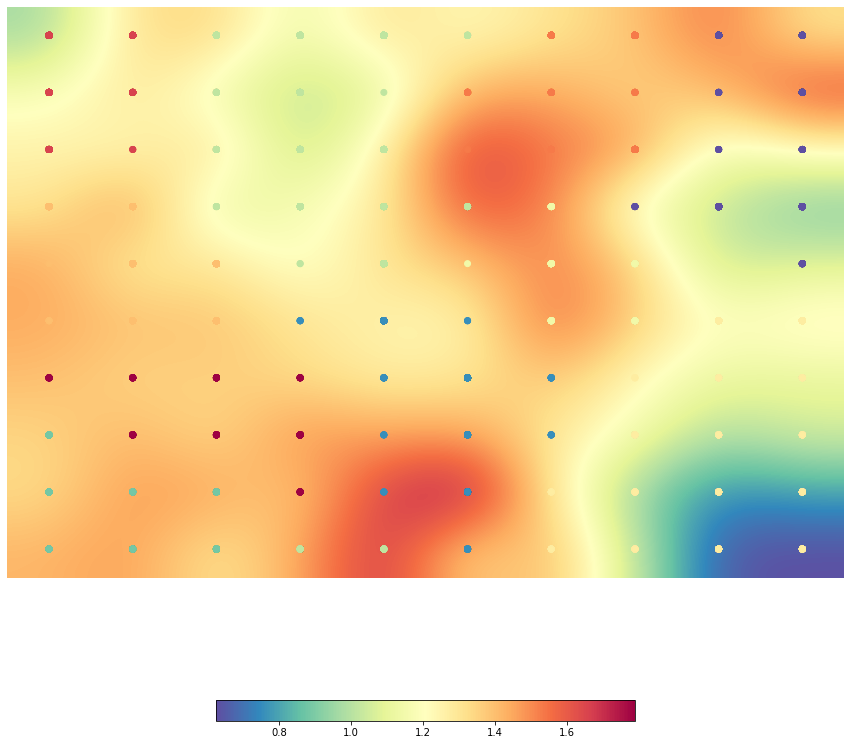

[[8 8 3 3 3 3 7 7 0 0]
 [8 8 3 3 3 7 7 7 0 0]
 [8 8 3 3 3 7 7 7 0 0]
 [6 6 3 3 3 3 4 0 0 0]
 [6 6 6 3 3 4 4 4 0 0]
 [6 6 6 1 1 1 4 4 5 5]
 [9 9 9 9 1 1 1 5 5 5]
 [2 9 9 9 1 1 1 5 5 5]
 [2 2 2 9 1 1 5 5 5 5]
 [2 2 2 3 3 1 5 5 5 5]]
The number of the unique best matching units:  99
The bmus for each movie are:  [60 77 70 ...  7  2 68]
The clusters and the number of nodes in descending order are:  [[3, 5, 1, 0, 7, 6, 9, 2, 8, 4], [18, 16, 12, 11, 8, 8, 8, 7, 6, 6]]


In [ ]:
algorithm = KMeans(n_clusters=10)
som1.cluster(algorithm=algorithm)
som1.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

print(som1.clusters)
bmus = som1.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of unique bmus is: ", len(ubmus))
print("The bmus for each movie are: ", indices)

# Get the largest and smallest clusters by number of nodes (movies)
counter = Counter(som1.clusters.flatten())
sorted_clusters = []
# Sort by values in counter
sorted_clusters.append([k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
sorted_clusters.append([v for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
print("The clusters and the number of nodes in descending order are: ", sorted_clusters)

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(5, som1))

{'Drama': 1067,
 'World cinema': 144,
 'Crime Fiction': 96,
 'Indie': 90,
 'Family Film': 87,
 'Comedy': 74,
 'Black-and-white': 73,
 'Animation': 64,
 'War film': 62,
 'Adventure': 59,
 'Period piece': 55,
 'Family Drama': 53,
 'Comedy film': 48,
 'Fantasy': 39,
 'Film adaptation': 39,
 'Sports': 37,
 'Musical': 36,
 'Television movie': 35,
 'Biographical film': 34,
 'Biography': 34,
 'Melodrama': 30,
 'Action/Adventure': 29,
 'Coming of age': 29,
 'Japanese Movies': 28,
 'Political drama': 28,
 "Children's/Family": 26,
 'Docudrama': 25,
 'Art film': 22,
 'Biopic [feature]': 22,
 "Children's": 22,
 'Short Film': 20,
 'Thriller': 17,
 'Chinese Movies': 16,
 'Computer Animation': 15,
 'Crime Drama': 15,
 'Film noir': 15,
 'History': 15,
 'Music': 15,
 'Western': 15,
 'Romance Film': 14,
 'Costume drama': 13,
 'Historical fiction': 13,
 'Mystery': 13,
 'Science Fiction': 13,
 'Black comedy': 12,
 "Children's Fantasy": 11,
 'Horror': 11,
 'Christian film': 10,
 'Courtroom Drama': 10,
 'Do

Για το συγκεκριμένο cluster φαίνεται ότι έγινε υπερβολικά μεγάλη ομαδοποίηση που ξεπερνάει τα όρια.

### Δοκιμάζουμε kmeans πάνω στο ίδιο SOM με n_clusters = 25 

/home/manos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


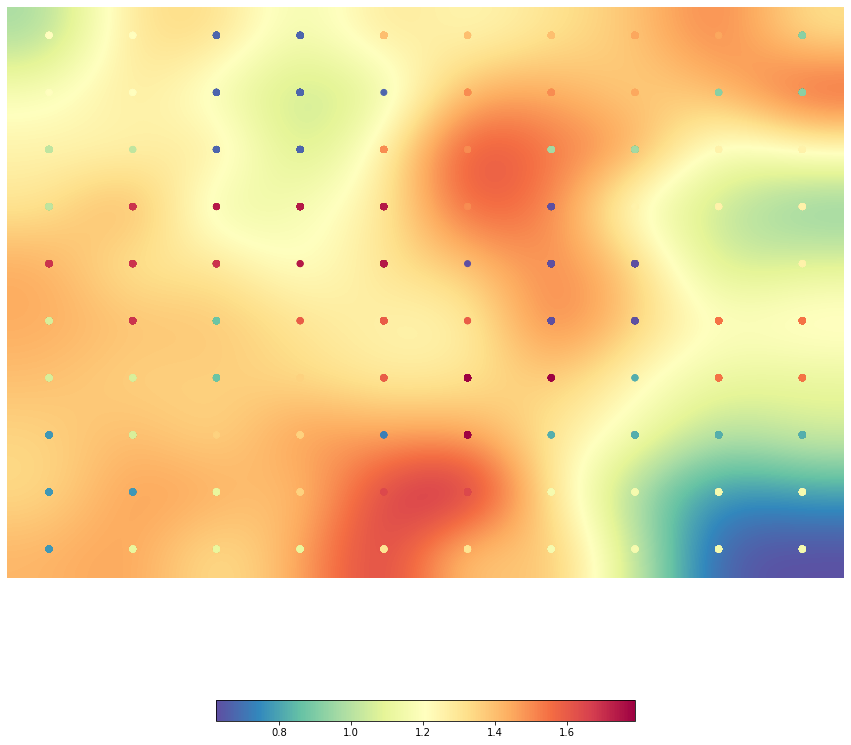

[[12 12  1  1 16 16 16 17 17  6]
 [12 12  1  1  1 18 18 17  6  6]
 [ 8  8  1  1 18 18  7  7 13 13]
 [ 8 22 23 23 23 18  0 13 13 13]
 [22 22 22 23 23  0  0  0 13 13]
 [ 9 22  5 20 20 20  0  0 19 19]
 [ 9  9  5 15 20 24 24  4 19 19]
 [ 3  9 15 15  2 24  4  4  4  4]
 [ 3  3 10 15 21 21 11 11 11 11]
 [ 3 10 10 10 14 14 11 11 11 11]]
The number of the unique best matching units:  99
The bmus for each movie are:  [60 77 70 ...  7  2 68]
The clusters and the number of nodes in descending order are:  [[11, 1, 13, 0, 18, 22, 23, 4, 12, 9, 20, 19, 15, 3, 10, 16, 17, 6, 8, 24, 7, 5, 21, 14, 2], [8, 7, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1]]


In [ ]:
algorithm = KMeans(n_clusters=25)
som1.cluster(algorithm=algorithm)
som1.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

print(som1.clusters)
bmus = som1.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of unique bmus is: ", len(ubmus))
print("The bmus for each movie are: ", indices)

# Get the largest and smallest clusters by number of nodes (movies)
counter = Counter(som1.clusters.flatten())
sorted_clusters = []
# Sort by values in counter
sorted_clusters.append([k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
sorted_clusters.append([v for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
print("The clusters and the number of nodes in descending order are: ", sorted_clusters)

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(19, som1))

{'Drama': 203,
 'Comedy': 54,
 'Indie': 48,
 'Black-and-white': 28,
 'Family Drama': 28,
 'Crime Fiction': 23,
 'Family Film': 18,
 'Film adaptation': 16,
 'Melodrama': 15,
 'Period piece': 15,
 'Coming of age': 13,
 'Sports': 11,
 'Television movie': 11,
 'Comedy film': 7,
 'Adventure': 6,
 'Biography': 6,
 'Black comedy': 6,
 'Fantasy': 6,
 'Musical': 6,
 'Action/Adventure': 5,
 'Buddy film': 5,
 "Children's/Family": 5,
 'Political drama': 5,
 'Road movie': 5,
 'Costume drama': 4,
 'Film noir': 4,
 'Mystery': 4,
 'Teen': 4,
 'World cinema': 4,
 'Childhood Drama': 3,
 'Christian film': 3,
 'Comedy-drama': 3,
 'Courtroom Drama': 3,
 'Disaster': 3,
 'Marriage Drama': 3,
 'Science Fiction': 3,
 'Action': 2,
 'Americana': 2,
 'Biographical film': 2,
 'Biopic [feature]': 2,
 'Boxing': 2,
 "Children's": 2,
 'Crime Drama': 2,
 'Cult': 2,
 'Dystopia': 2,
 'Family-Oriented Adventure': 2,
 'Musical Drama': 2,
 'Remake': 2,
 'Romantic comedy': 2,
 'Romantic drama': 2,
 'Sex comedy': 2,
 'Short F

### Δοκιμάζουμε σε καινούριο χάρτη 30x30 νευρώνων με αριθμό clusters 60 για να μην έχουμε υπερβολικά μεγάλη ομαδοποίηση 

In [ ]:
n_rows, n_columns = 30, 30
som2 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som2.train(final_set, epochs=200)
#joblib.dump(som2, 'som2.pkl') 

CPU times: user 14min 35s, sys: 1.51 s, total: 14min 37s
Wall time: 1min 4s


['som2.pkl']

/home/manos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


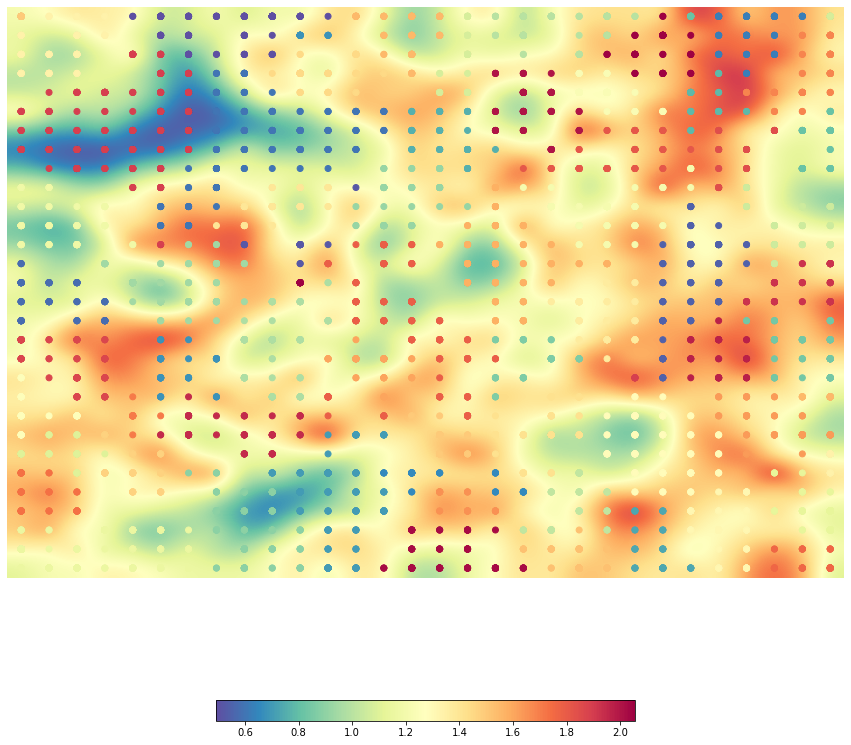

[[38 32 32 32  0  0  0  0  0  0  0  0 40 40 40 40 22 19 19 19 19 19 19 59
  12  5  5  5  5 22]
 [32 32 32 32 53  0  0  0  0  0  7  7 40 40 40 40 22 19 19 19 19 19 59 59
  59  5  5  5 45 45]
 [32 32 32 32 53 53  0  0  0  0 36 36 36 40 40 40 22 22 19 19 19 59 59 59
  59  5  5  5 45 45]
 [32 32 32 53 53 53 53  4  4 36 36 36 36 36 40 22 22 57 57 57 28 28 59 59
  59 11  5 45 45 45]
 [32 53 53 53 53 53 53  4  4  4 36 36 36 36 22 22 22 57 57 57 28 28 28 11
  11 11 45 45 45 45]
 [53 53 53 53 53 53 53  4  4  4  4  4  4  4 10 10 10 57 57 57 57 28 28 28
  11 11 11 45 45 12]
 [53 53 53 53 53 53 53  4  4  4  4  4  4  4 10 10 10 57 57 57 57 50 50 50
  11 51 51 51 12 12]
 [53 53 53 53 53 53 53  4  4  4  4  4  4 16 10 10 10 10 57 57 50 50 50 50
  50 51 51 51 12 12]
 [53 53 53 53 53 53  4  4  4  4  4  4  4 16 16 16 10 10 50 50 50 50 50 50
  27 51 51 12 12 12]
 [26 26 53 53 53 53  4  4 34 34 34 34  1 16 16 16 16 41 27 27 27 27 27 27
  27 51 21 21 21 21]
 [26 26 26 26 53  4  4  4 34 34 34 34 16 16 16 16 

In [ ]:
nclusters = 60
algorithm = KMeans(n_clusters=nclusters)
som2.cluster(algorithm=algorithm)
som2.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

bmus = som2.bmus

ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(som2.clusters)
print("The number of unique bmus is: ", len(ubmus))
print("The bmus for each movie are: ", indices)

counter = Counter(som2.clusters.flatten())
sorted_clusters = []
# Sort by values in counter
sorted_clusters.append([k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
sorted_clusters.append([v for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)])
print("The clusters and the number of nodes in ascending order are: ", sorted_clusters)

In [ ]:
#from itertools import islice

total_nodes = []
total_freqs = {}
for i in range(nclusters):
    freqs = neuron_movies_report(print_cluster_neurons_movies_report(i, som2))
    total_nodes.append(sum(freqs.values()))
    for key, value in freqs.items():
        if total_freqs.get(key):
            total_freqs[key] += value
        else:
            total_freqs[key] = value
    print("The total nodes of cluster", i, "are: ",sum(freqs.values()))
    print("The top 5 categories of cluster", i, "are: ", list(freqs.items())[:5])
    print("he bottom 5 categories of cluster", i, "are: ", list(freqs.items())[-5:])
    print()

total_freqs_sorted = [(k, v) for k, v in sorted(total_freqs.items(), key=operator.itemgetter(1), reverse=True)]
print("The categories of all movies", total_freqs_sorted)

Total nodes of cluster 0 are:  186
Top 5 categories of cluster 0 are:  [('Drama', 44), ('Comedy', 25), ('Western', 22), ('Silent film', 13), ('Parody', 11)]
Bottom 5 categories of cluster 0 are:  [('Sports', 1), ('Teen', 1), ('Television movie', 1), ('Time travel', 1), ('Workplace Comedy', 1)]

Total nodes of cluster 1 are:  57
Top 5 categories of cluster 1 are:  [('Drama', 15), ('Comedy film', 13), ('Black-and-white', 5), ('Indie', 5), ('Crime Fiction', 3)]
Bottom 5 categories of cluster 1 are:  [('Japanese Movies', 1), ('Marriage Drama', 1), ('Mystery', 1), ('Roadshow theatrical release', 1), ('Short Film', 1)]

Total nodes of cluster 2 are:  633
Top 5 categories of cluster 2 are:  [('Drama', 130), ('World cinema', 93), ('Romance Film', 89), ('Romantic drama', 86), ('Thriller', 49)]
Bottom 5 categories of cluster 2 are:  [('Political thriller', 1), ('Romantic fantasy', 1), ('Social problem film', 1), ('Teen', 1), ('Whodunit', 1)]

Total nodes of cluster 3 are:  288
Top 5 categories o

In [ ]:
# Για το ερώτημα 2
print("The categories for cluster 26 are: ", neuron_movies_report(print_cluster_neurons_movies_report(26, som2)))
print()
print("The categories for cluster 58 are: ", neuron_movies_report(print_cluster_neurons_movies_report(58, som2)))

The categories for cluster 26 are:  {'Short Film': 71, 'Animation': 55, 'Comedy': 52, 'Drama': 32, 'Family Film': 21, 'Adventure': 11, 'Computer Animation': 10, 'Fantasy': 9, 'Docudrama': 8, 'Buddy film': 5, 'Road movie': 4, 'Silent film': 4, 'World cinema': 4, 'Black comedy': 3, "Children's": 3, 'Courtroom Drama': 3, 'Horror': 3, 'Indie': 3, 'Romance Film': 3, 'Action': 2, 'Cult': 2, 'Music': 2, 'Musical': 2, 'Prison': 2, 'Science Fiction': 2, 'Stop motion': 2, 'Teen': 2, 'Television movie': 2, 'Absurdism': 1, 'Action/Adventure': 1, 'Airplanes and airports': 1, 'Americana': 1, 'Anime': 1, 'Art film': 1, 'Avant-garde': 1, 'Biography': 1, 'Black-and-white': 1, 'Christian film': 1, 'Comedy film': 1, 'Comedy of Errors': 1, 'Coming of age': 1, 'Crime Drama': 1, 'Crime Fiction': 1, 'Ensemble Film': 1, 'Experimental film': 1, 'Exploitation': 1, 'Fantasy Comedy': 1, 'Film adaptation': 1, 'Historical fiction': 1, 'Horror Comedy': 1, 'Marriage Drama': 1, 'Medical fiction': 1, 'Mockumentary': 1,

In [ ]:
# Για το ερώτημα 3
print("The categories for cluster 53 are: ", neuron_movies_report(print_cluster_neurons_movies_report(53, som2)))
print()
print("The categories for cluster 26 are: ", neuron_movies_report(print_cluster_neurons_movies_report(26, som2)))

The categories for cluster 53 are:  {'Drama': 270, 'Short Film': 93, 'Comedy': 49, 'Family Film': 40, 'Animation': 37, 'Period piece': 14, 'Biographical film': 11, 'Adventure': 10, 'Television movie': 10, 'World cinema': 10, "Children's/Family": 9, 'Science Fiction': 9, 'Biography': 7, 'Biopic [feature]': 7, 'Musical': 7, 'Political drama': 7, 'Black comedy': 6, 'Film adaptation': 6, 'Thriller': 6, 'Black-and-white': 5, 'Japanese Movies': 5, 'Action': 4, 'Costume drama': 4, 'Docudrama': 4, 'Experimental film': 4, 'Mystery': 4, 'Psychological thriller': 4, 'Satire': 4, 'Silent film': 4, "Children's": 3, 'Comedy film': 3, 'Courtroom Drama': 3, 'Epic': 3, 'Fantasy': 3, 'Fantasy Comedy': 3, 'Romance Film': 3, 'Romantic drama': 3, 'Teen': 3, 'Art film': 2, 'Avant-garde': 2, 'Buddy film': 2, 'Chase Movie': 2, 'Chinese Movies': 2, 'Christmas movie': 2, 'Crime Fiction': 2, 'Domestic Comedy': 2, 'Family Drama': 2, 'Filipino Movies': 2, 'Film noir': 2, 'Historical drama': 2, 'Historical fiction'

In [ ]:
# Για το ερώτημα 3
print("The categories for cluster 38 are: ", neuron_movies_report(print_cluster_neurons_movies_report(38, som2)))

The categories for cluster 38 are:  {'World cinema': 35, 'Romance Film': 31, 'Bollywood': 27, 'Drama': 26, 'Musical': 26, 'Comedy': 18, 'Action': 16, 'Adventure': 10, 'Horror': 8, 'War film': 5, 'Chinese Movies': 3, 'Art film': 2, 'Black comedy': 2, 'History': 2, 'Thriller': 2, 'Comedy film': 1, 'Comedy-drama': 1, 'Family Film': 1, 'Filipino Movies': 1, 'Horror Comedy': 1, 'Japanese Movies': 1, 'Musical Drama': 1, 'Psychological thriller': 1, 'Romantic drama': 1, 'Screwball comedy': 1, 'Sex comedy': 1, 'Short Film': 1, 'Silent film': 1, 'Sports': 1, 'Tamil cinema': 1, 'Television movie': 1, 'Tragicomedy': 1, 'Western': 1}


## Ανάλυση Τοπολογικών Ιδιοτήτων SOM
Το kmeans ομαδοποιεί νευρώνες με κοντική απόστασημεταξύ τους, οπότε οι ταινίες που αναθέτονται στους αντίστοχους νευρώνες θα έχουν και κοινά θεματικά χαρακτηριστικά μεταξύ τους.
1. Με βάση το λεξικό total_freqs, οι πιο συχνές κατηγορίες ταινιών είναι και οι αντίστοιχες συχνότητες είναι: 
('Drama', 2013), ('Comedy', 1048), ('Romance Film', 669), ('Thriller', 646), ('Action', 615)
Ενώ υπάρχουν πολλές κατηγορίες με μόνο μια ταινία, κάποιες από αυτές είναι:
'Bengali Cinema': 1, 'Education': 1, 'Race movie': 1, 'Fan film': 1, 'Giallo': 1, 'Interpersonal Relationships': 1, 'Kafkaesque': 1, 'Psycho-biddy': 1, 'Tokusatsu': 1}

2. Tα clusters 26 και 58 βρίσκονται αρκετά μακριά στον χάρτη SOM. Ενώ το ένα cluster περιέχει ταινίες 'Drama', 'Short Film', 'Comedy', 'Family Film', και 'Animation', το άλλο περιέχει ταινίες 'Romance Film', 'Horror', 'Drama', 'Slasher', και 'Action'. Τα clusters αυτά έχουν αρκετές θεματικές διαφορές στο περιεχόμενό τους και για αυτό βρίσκονται μακριά μεταξύ τους. 

3. Το πάνω αριστερό κομμάτι του SOM (όπου βρίσκονται τα clusters 53 και 26) περιέχει κυρίως παιδικές ταινίες κινουμένων σχεδίων. Τα πιο συχνά είδη ταινιών είναι 'Drama', 'Short Film', 'Comedy', 'Animation', και 'Family Film'.

Ένα μικρό cluster που δεν έχει σαφή χαρακτηριστικά είναι το 47 με κύριες κατηγορίες τις 'Drama', 'World Cinema', 'Comedy', και 'Comedy-Drama', ενώ ένα μεγάλο είναι το 25 με κύριες κατηγορίες τις 'Drama', 'Comedy', 'Family Film', 'Indie', και 'World Cinema'. 

Παρατηρούμε ότι το cluster 38 έχει πιο συχνές κατηγορίες τις 'World Cinema', 'Romance Film', 'Bollywood', 'Drama', και 'Musical', και βρίσκεται απομονωμένο σε σχέση με τα άλλα clusters. Αυτό προκύπτει επειδή έχει ταινίες που είναι αρκετά ξεχωριστές σε σχέση με τις υπόλοιπες στο dataset μας.